## <font color='darkred'> Inteligência Artificial em Finanças </font>
    
### <font color='darkgreen'>Lab 1 - Parte 3 - Modelo SARIMAX</font>

### <font color='darkblue'>Forecast de títulos de Renda Fixa ao longo do tempo</font>

### <font color='darkblue'>Instalando e Carregando Pacotes</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 12
m.rcParams['xtick.labelsize'] = 10
m.rcParams['ytick.labelsize'] = 10
m.rcParams['text.color'] = 'k'

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Michelle Bouhid" --iversions

Author: Michelle Bouhid

numpy      : 1.23.5
pandas     : 1.5.3
statsmodels: 0.14.0
platform   : 1.0.8
matplotlib : 3.7.1
sklearn    : 1.3.0



### <font color='darkblue'>Carregando Dados</font>

In [5]:
# Carrega os dados
dados_treino = pd.read_csv("dados/dataset_treino.csv")
dados_teste = pd.read_csv("dados/dataset_teste.csv")

In [6]:
# Converte a coluna data para o tipo correto
dados_treino['data'] = pd.to_datetime(dados_treino.data, format = '%d-%m-%Y %H:%M')

In [7]:
# Converte a coluna data para o tipo correto
dados_teste['data'] = pd.to_datetime(dados_teste.data, format = '%d-%m-%Y %H:%M')

In [8]:
# Vamos extrair os detalhes da coluna data: ano, mês, dia e hora
for i in (dados_treino, dados_teste):
    i['ano'] = i.data.dt.year
    i['mes'] = i.data.dt.month
    i['dia'] = i.data.dt.day
    i['hora'] = i.data.dt.hour

In [9]:
# Precisamos do dia da semana também
dados_treino['dia_semana'] = dados_treino['data'].dt.dayofweek

In [10]:
# Vejamos como ficou o dataset
dados_treino.head()

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
0,0,2020-08-25 00:00:00,8,2020,8,25,0,1
1,1,2020-08-25 01:00:00,2,2020,8,25,1,1
2,2,2020-08-25 02:00:00,6,2020,8,25,2,1
3,3,2020-08-25 03:00:00,2,2020,8,25,3,1
4,4,2020-08-25 04:00:00,2,2020,8,25,4,1


In [11]:
# Refinamos os dados para o gráfico da série original

# Definimos o índice do dataset
dados_treino.index = dados_treino['data']

# Removemos a coluna ID, pois ela não é relevante neste caso
features = dados_treino.drop('id', axis = 1)

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dados_treino['valor_titulo']

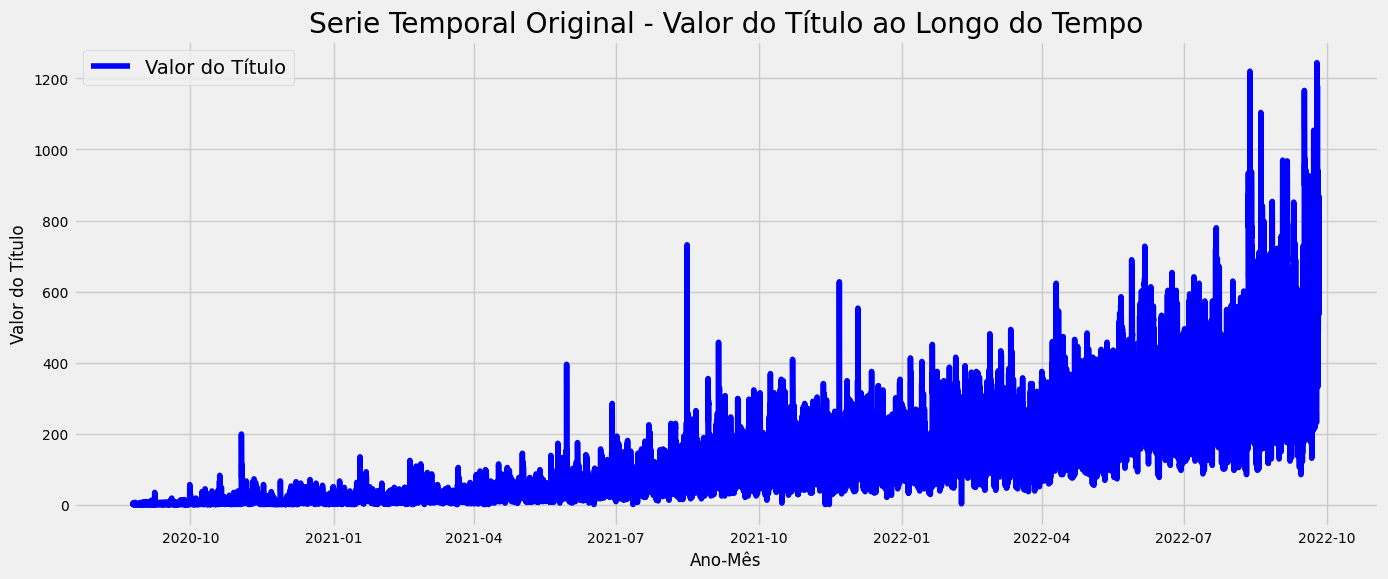

In [12]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal Original - Valor do Título ao Longo do Tempo")
plt.plot(target, label = "Valor do Título", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Valor do Título")
plt.legend(loc = "best")

### <font color='darkblue'>Pré-Processamento</font>

Vamos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [13]:
# Os dados de treino serão divididos em dados de treino e validação.
# Observe que os registros são separados em ordem cronológica.
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

In [14]:
df_treino.shape

(16057, 8)

In [15]:
df_valid.shape

(2230, 8)

Para Modelos ARIMA devemos remover a tendência. Vamos fazer isso.

In [16]:
# Aplicando transformação de log
df_treino_log = np.log(df_treino['valor_titulo']) 

In [17]:
# Moving Average (Média Móvel)
media_movel = df_treino_log.rolling(24).mean() 

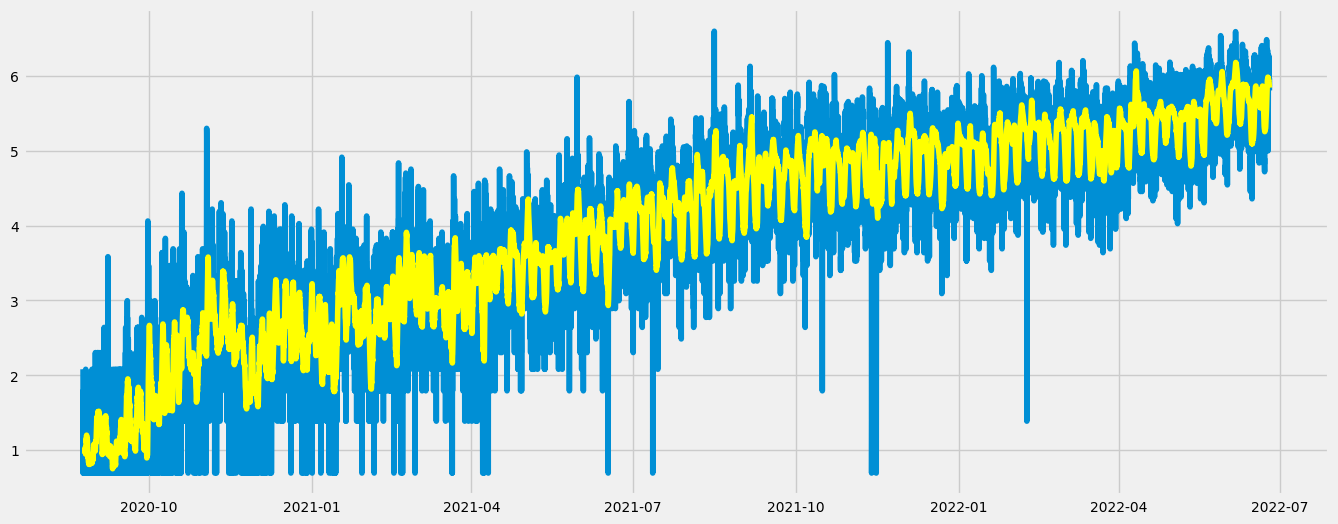

In [18]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log) 
plt.plot(media_movel, color = 'yellow') 
plt.show()

In [19]:
# Diferenciação
df_treino_media_movel_diff = df_treino_log - media_movel
df_treino_media_movel_diff.dropna(inplace = True) 

In [20]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    figure(figsize = (15, 6))
    orig = plt.plot(serie, color = 'green', label = 'Original')
    mean = plt.plot(rolmean, color = 'orange', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'blue', label = 'Desvio Padrão')
    
    # Gráfico
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

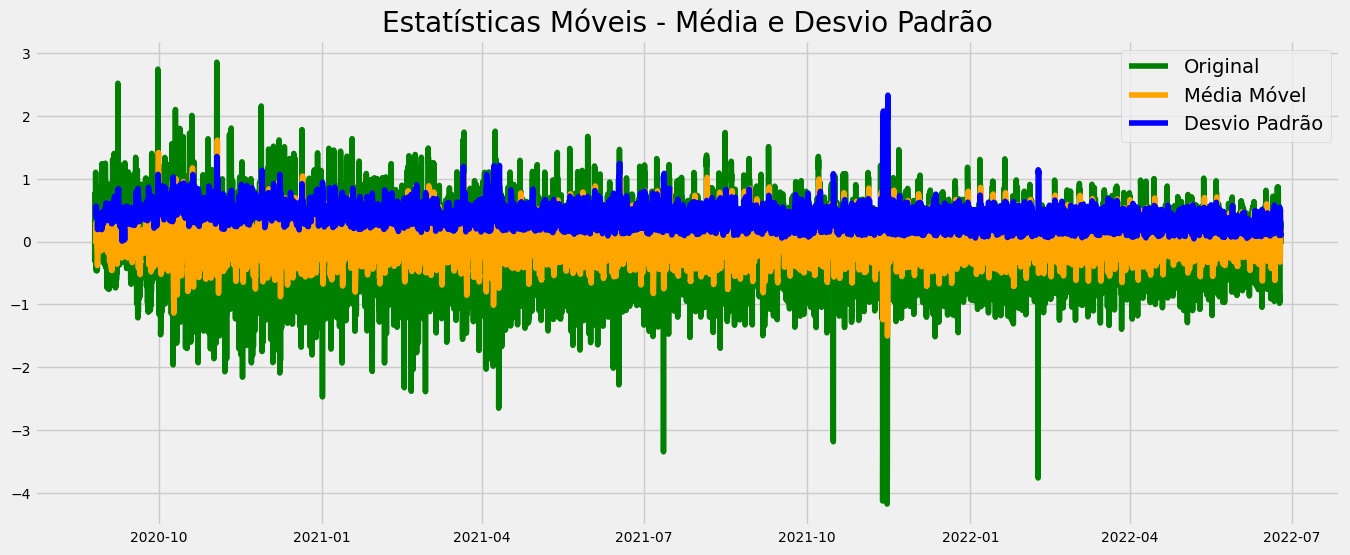


Resultado do Teste Dickey-Fuller:

Estatística do Teste              -22.471885
Valor-p                             0.000000
Número de Lags Consideradas        43.000000
Número de Observações Usadas    15990.000000
Valor Crítico (1%)                 -3.430759
Valor Crítico (5%)                 -2.861721
Valor Crítico (10%)                -2.566866
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [21]:
# Aplica a função para checar a estacionaridade
testa_estacionaridade(df_treino_media_movel_diff)

## <font color = 'darkred'> Forecasting - Modelagem Preditiva Para Séries Temporais </font>

### <font color='darkblue'> Implementando a Estratégia 4 de Forecasting - Modelo SARIMAX</font>

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [22]:
# Cria o modelo
modelo_SARIMAX = SARIMAX(df_treino_log, trend = 'n', order = (6,1,1), seasonal_order = (0,1,1,24)) 
# possivel mudança a cada 24 horas

Parâmetro trend = 'n': Este argumento define a tendência do modelo. Aqui, 'n' significa que nenhum componente de tendência é incluído no modelo.

Parâmetro order = (6,1,0): Estes são os parâmetros do modelo ARIMA. 

O primeiro número, 6, é a parte "AR" ou autoregressiva do modelo. Isso significa que o modelo considerará os seis valores anteriores da série temporal para fazer uma previsão. 

O segundo número, 1, é a parte "I" ou integrada do modelo. Isso se refere ao número de vezes que a série temporal é diferenciada para tornar a série estacionária. Neste caso, os dados são diferenciados uma vez. 

O último número, 0, é a parte "MA" ou média móvel do modelo. Isso indica que o modelo não considerará o erro da previsão do último período na previsão do próximo período.

Parâmetro seasonal_order = (0,1,1,24): Estes são os parâmetros para o componente sazonal do modelo SARIMAX.

- O primeiro número, 0, é o número de termos autoregressivos sazonais (SAR).
- O segundo número, 1, é a ordem de diferenciação sazonal (D), que é o número de vezes que a série temporal é diferenciada para remover a sazonalidade.
- O terceiro número, 1, é o número de termos de média móvel sazonais (SMA).
- O último número, 24, é o período do componente sazonal. No nosso caso 24 horas.

In [25]:
# colocando o time porque demora mesmo
%%time 
modelo_v4 = modelo_SARIMAX.fit(disp = True)

Wall time: 2min 25s


In [26]:
# Dados Reais e Previsões (em treino)
dados_reais = df_treino_log
previsoes_v4 = modelo_v4.fittedvalues

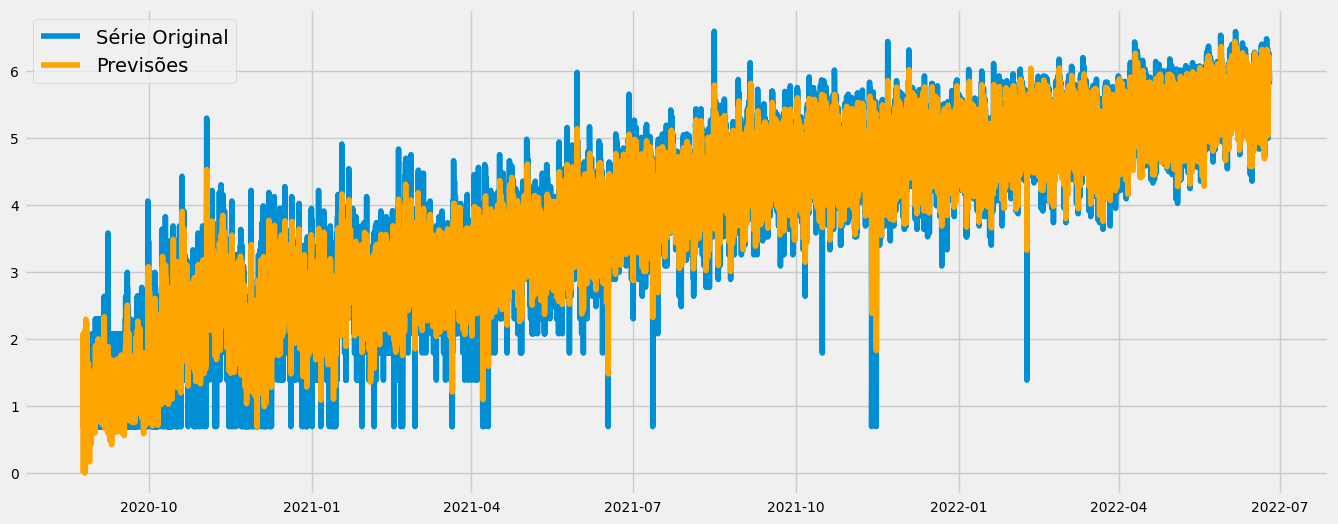

In [27]:
# Plot
figure(figsize = (15, 6))
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes_v4, color = 'orange', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

In [28]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
df_valid_log = np.log(df_valid['valor_titulo'])

In [29]:
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
# usamos método forecast
df_previsoes_v4 = modelo_v4.forecast(len(df_valid_log), alpha = 0.05) 

In [30]:
df_previsoes_v4.shape

(2230,)

In [31]:
# Cria a série para o gráfico
fc_series = pd.Series(df_previsoes_v4, index = df_valid_log.index)

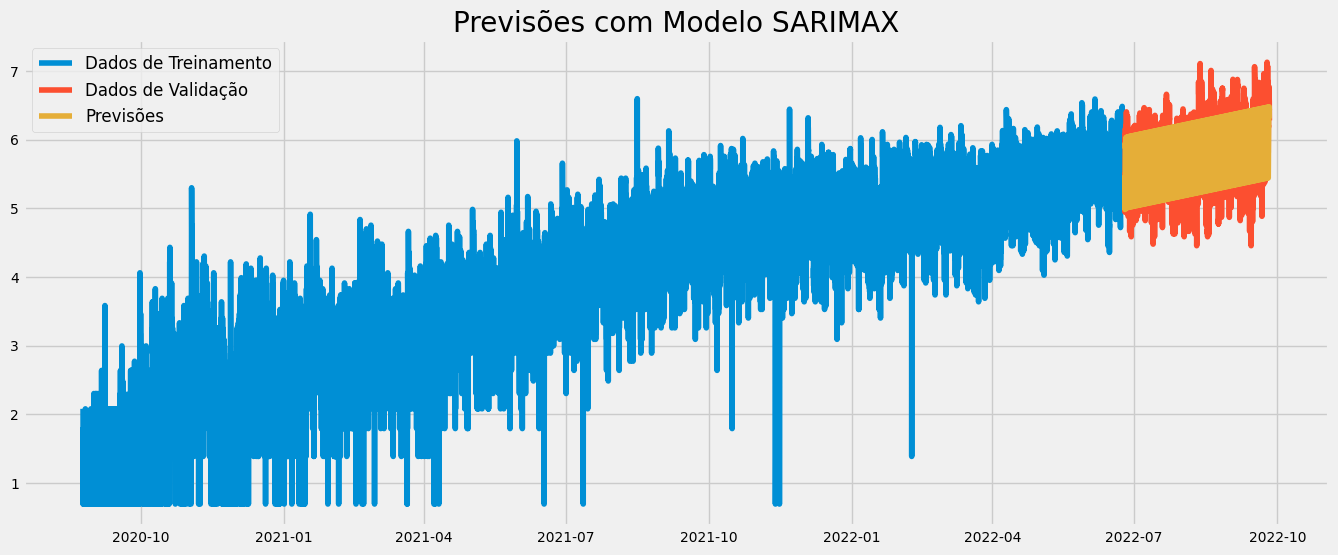

In [32]:
# Plot
figure(figsize = (15, 6))
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.title('Previsões com Modelo SARIMAX')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [33]:
# Replace de valores NaN por 0
fc_series = fc_series.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [34]:
# Define valor real e valor previsto
# Usou o df.valid pq tem os dados reais, pra comparar com a previsão.
# Usamos no metodo forecast, quando temos o valor real para comparar com a previsão e calcular o erro
y_true = df_valid_log
y_pred = fc_series

In [35]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.343501887544871


### <font color='darkblue'> Previsão com Novos Dados</font>

In [36]:
# Vamos fazer a previsão para uma janela de 30 unidades da série temporal
# Usamos metodo predict aqui, acima foi metodo forecast!
# janela de 30, no caso 30 horas
# Usamos o predict quando ja nao temos mais os dados reais para comparar com a previsão e avaliar o modelo
# modelo já está em uso - usa metodo predict, com df de teste, que já não tem mais o valor real
previsoes = modelo_v4.predict(start = dados_teste.data[0], end = dados_teste.data[30], dynamic = False)

In [37]:
# usamos dados de validação, pois tem o valor real do título
df_valid.head()

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
data,,,,,,,,
2022-06-25 02:00:00,16058,2022-06-25 02:00:00,218,2022,6,25,2,5
2022-06-25 03:00:00,16059,2022-06-25 03:00:00,244,2022,6,25,3,5
2022-06-25 04:00:00,16060,2022-06-25 04:00:00,168,2022,6,25,4,5
2022-06-25 05:00:00,16061,2022-06-25 05:00:00,140,2022,6,25,5,5
2022-06-25 06:00:00,16062,2022-06-25 06:00:00,156,2022,6,25,6,5


In [38]:
# Vai até 25.09.22, onde temos os valores reais para comparar
df_valid.tail()

,id,data,valor_titulo,ano,mes,dia,hora,dia_semana
data,,,,,,,,
2022-09-25 19:00:00,18283,2022-09-25 19:00:00,868,2022,9,25,19,6
2022-09-25 20:00:00,18284,2022-09-25 20:00:00,732,2022,9,25,20,6
2022-09-25 21:00:00,18285,2022-09-25 21:00:00,702,2022,9,25,21,6
2022-09-25 22:00:00,18286,2022-09-25 22:00:00,580,2022,9,25,22,6
2022-09-25 23:00:00,18287,2022-09-25 23:00:00,534,2022,9,25,23,6


In [39]:
# Ja nao tem mais valores reais pra comparar, já estamos usando em produção, fizemos o Deploy
# testa ja começa com 25.09.22, onde ja não temos mais o valores reais, já é previsão do modelo
dados_teste.head()

,id,data,ano,mes,dia,hora
0,18288,2022-09-26 00:00:00,2022,9,26,0
1,18289,2022-09-26 01:00:00,2022,9,26,1
2,18290,2022-09-26 02:00:00,2022,9,26,2
3,18291,2022-09-26 03:00:00,2022,9,26,3
4,18292,2022-09-26 04:00:00,2022,9,26,4


In [40]:
dados_teste.data[0]

Timestamp('2022-09-26 00:00:00')

In [41]:
dados_teste.data[30]

Timestamp('2022-09-27 06:00:00')

In [42]:
type(previsoes)

pandas.core.series.Series

In [43]:
previsoes[1:30]

2022-09-26 01:00:00    6.109088
2022-09-26 02:00:00    5.940921
2022-09-26 03:00:00    5.764015
2022-09-26 04:00:00    5.601634
2022-09-26 05:00:00    5.445639
2022-09-26 06:00:00    5.505617
2022-09-26 07:00:00    5.631301
2022-09-26 08:00:00    5.788052
2022-09-26 09:00:00    6.030754
2022-09-26 10:00:00    6.298767
2022-09-26 11:00:00    6.389047
2022-09-26 12:00:00    6.412072
2022-09-26 13:00:00    6.326579
2022-09-26 14:00:00    6.399235
2022-09-26 15:00:00    6.397707
2022-09-26 16:00:00    6.374553
2022-09-26 17:00:00    6.381686
2022-09-26 18:00:00    6.413848
2022-09-26 19:00:00    6.482208
2022-09-26 20:00:00    6.481990
2022-09-26 21:00:00    6.433961
2022-09-26 22:00:00    6.450079
2022-09-26 23:00:00    6.391267
2022-09-27 00:00:00    6.302690
2022-09-27 01:00:00    6.113872
2022-09-27 02:00:00    5.945705
2022-09-27 03:00:00    5.768799
2022-09-27 04:00:00    5.606418
2022-09-27 05:00:00    5.450423
Freq: H, Name: predicted_mean, dtype: float64

In [44]:
# Inversa da transformação de log
np.exp(previsoes[1:30])

2022-09-26 01:00:00    449.928240
2022-09-26 02:00:00    380.284874
2022-09-26 03:00:00    318.625130
2022-09-26 04:00:00    270.868595
2022-09-26 05:00:00    231.745300
2022-09-26 06:00:00    246.070189
2022-09-26 07:00:00    279.024829
2022-09-26 08:00:00    326.376711
2022-09-26 09:00:00    416.028452
2022-09-26 10:00:00    543.900846
2022-09-26 11:00:00    595.289003
2022-09-26 12:00:00    609.154306
2022-09-26 13:00:00    559.240319
2022-09-26 14:00:00    601.384508
2022-09-26 15:00:00    600.466475
2022-09-26 16:00:00    586.723302
2022-09-26 17:00:00    590.923031
2022-09-26 18:00:00    610.237298
2022-09-26 19:00:00    653.411913
2022-09-26 20:00:00    653.269818
2022-09-26 21:00:00    622.635222
2022-09-26 22:00:00    632.752101
2022-09-26 23:00:00    596.612136
2022-09-27 00:00:00    546.038766
2022-09-27 01:00:00    452.085811
2022-09-27 02:00:00    382.108479
2022-09-27 03:00:00    320.153054
2022-09-27 04:00:00    272.167509
2022-09-27 05:00:00    232.856604
Freq: H, Name: